### PINO/FNO Architecture 

This model was influenced by Bilal Thonnam Thodi on their work [1].

[1] B. T. Thodi, S. V. R. Ambadipudi, and S. E. Jabari. Fourier neural operator for learning
solutions to macroscopic traffic flow models: Application to the forward and inverse
problems, 2023 - code https://github.com/bilzinet/pifno

#-----------------------------------------------------------------------------------------

Copyright information from Bilal Thonnam Thodi

''MIT License

Copyright (c) 2022 Bilal Thonnam Thodi

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.''

#-----------------------------------------------------------------------------------------

## Approximating a Solution to the 1D parabolic Equation for $\kappa$ = 1 using the FNO architecture

Consider the 1D parabolic equation

\begin{equation}
    u_t = u_{xx} - \kappa^2 u \quad \textrm{ for } x \in \left( -1, 2 \right), t \in \left( 0, T \right),
\end{equation}

subject to an initial condition

\begin{equation}
    u \left( x, t = 0 \right) = \sin \left( \kappa x \right) + 2 \sin \left( 2 \kappa x \right)
\end{equation}

and homogeneous Dirichlet boundary conditions

\begin{equation}
  u \left( x = -1, t \right) = u \left( x = 2, t \right) = 0
\end{equation}

Here, we use 33 train samples, 1 test samples both with grid resolution of 61  x  40.

In [502]:
# load packages
import sys
import numpy as np
import torch
import torch.nn as nn
import pickle as pkl
import torch.nn.functional as F
## added extra
import os
##
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
np.random.seed(0)
torch.manual_seed(0)
#replaced cpu with cuda
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
print(device)

# Fourier Neural Operator
#Fourier Neural Operator (Reference: https://arxiv.org/pdf/2010.08895.pdf)
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        """
        2D Fourier layer: FFT -> Linear Transform -> Inverse FFT  
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1 (floor rounds down)
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, 2))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, 2))

    def forward(self, x):
        # Perform Fourier transform
        batchsize = x.shape[0]
        # Compute the real-valued 2D Fourier transform
        #print(f'x new = {x.shape}')
        x_ft = torch.fft.rfft2(x, norm="ortho") ##??
        #print(f'xft: {x_ft.shape}')
        #print(f'weights1: {self.weights1.shape}')
        # Multiply top Fourier modes with Fourier weights
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            torch.einsum('bixy,ioxy->boxy',x_ft[:, :, :self.modes1, :self.modes2],torch.view_as_complex(self.weights1))
            # compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
            
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            torch.einsum('bixy,ioxy->boxy',x_ft[:, :, :self.modes1, :self.modes2],torch.view_as_complex(self.weights2))
            #compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # Perform Inverse Fourier transform
        #x = torch.fft.irfft(out_ft, 2, normalized=True, onesided=True, signal_sizes=( x.size(-2), x.size(-1)))
        # Compute the inverse real-valued 2D Fourier transform
        x = torch.fft.irfft2(out_ft, norm="ortho")
        return x

class SimpleBlock2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(SimpleBlock2d, self).__init__()
        """
        The overall network. It contains 4-8 Fourier layers.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4-8 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.w4 = nn.Conv1d(self.width, self.width, 1)
        self.w5 = nn.Conv1d(self.width, self.width, 1)
        self.w6 = nn.Conv1d(self.width, self.width, 1)
        self.w7 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        batchsize = x.shape[0]
        size_x, size_y = x.shape[1], x.shape[2]
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        x1 = self.conv0(x)
        x2 = self.w0(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2
        x = F.relu(x)
        # FNO Layer 2
        
        x1 = self.conv1(x)
        x2 = self.w1(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2
        x = F.relu(x)
        # FNO Layer 3
        x1 = self.conv2(x)
        x2 = self.w2(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2
        x = F.relu(x)
        
        # FNO Layer 4
        x1 = self.conv3(x)
        x2 = self.w3(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2
        x = F.relu(x)
        '''
        # FNO Layer 5
        x1 = self.conv3(x)
        x2 = self.w4(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2
        x = F.relu(x)
        
        # FNO Layer 6
        x1 = self.conv3(x)
        x2 = self.w5(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2
        x = F.relu(x)
        
        # FNO Layer 7
        x1 = self.conv3(x)
        x2 = self.w6(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2
        x = F.relu(x)
        # FNO Layer 8
        x1 = self.conv3(x)
        x2 = self.w7(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = x1 + x2
        x = F.relu(x)
        '''
        # Projection Q
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()
        """
        A wrapper function
        """
        self.conv1 = SimpleBlock2d(modes1, modes2,  width)

    def forward(self, x):
        x = self.conv1(x)
        return x.squeeze()

    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))
        return c
    
class DataLoss(object):
    def __init__(self, p=2):
        super(DataLoss, self).__init__()
        self.p = p

    def data_loss(self, x, y):
        num_examples = x.size()[0]
        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)
        return torch.mean(diff_norms/y_norms)
    
    def __call__(self, x, y):
        return self.data_loss(x, y)
    
# initiale weights
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    if type(m) == torch.nn.Conv1d:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

# random masking of boundary values
def rand_mask(x_test, mp=0):
    if mp==0:
        return x_test
    else:
        mk=int(mp*x_test.shape[1])
        mind=np.random.randint(0,x_test.shape[1],size=(x_test.shape[0],mk))
        for i in range(mind.shape[0]):
            x_test[...,0][i,mind[i,:]]=-1
            x_test[...,-1][i,mind[i,:]]=-1
        return x_test
    
#load data
def load_data(f_names_train, f_names_test, data_fold_train, data_fold_test, b_size, ntest_sc, ntest_max, train=True, normalize=True, **kwargs):
    
    # load test data
    x_test = []; y_test = []
    for f in f_names_test:
        with open(data_fold_test+f'{f}.pkl','rb') as f:
            data = pkl.load(f)
        x_test.append(data['X'][:ntest_sc])
        y_test.append(data['Y'][:ntest_sc])
    x_test = np.concatenate(x_test, axis=0).astype(np.float32)
    y_test = np.concatenate(y_test, axis=0).astype(np.float32)
    x_test = x_test[:ntest_max,:,:]
    y_test = y_test[:ntest_max,:,:]
    x_test[:,1:,1:-1] = -1
    x_test = torch.from_numpy(x_test)
    y_test = torch.from_numpy(y_test)
    
    # grid size params
    s1 = x_test.shape[1]
    s2 = x_test.shape[2]
    ntest = x_test.shape[0]
    
    # load train data if required
    ntrain = 0
    if train:
        x_train = []; y_train = []
        for f in f_names_train:
            with open(data_fold_train+f'{f}.pkl','rb') as f:
                data = pkl.load(f)
            x_train.append(data['X'][:ntrain_sc])
            y_train.append(data['Y'][:ntrain_sc])
        x_train = np.concatenate(x_train, axis=0).astype(np.float32)
        y_train = np.concatenate(y_train, axis=0).astype(np.float32)
        x_train = x_train[:ntrain_max,:,:]
        y_train = y_train[:ntrain_max,:,:]
        x_train[:,1:,1:-1] = -1
        x_train = torch.from_numpy(x_train)
        y_train = torch.from_numpy(y_train)    
        ntrain = x_train.shape[0]
    
    # concat location coordinates
    grids = []
    grids.append((np.linspace(1,600,s1)+np.linspace(0,600-1,s1))/2)   
    grids.append((np.linspace(20,1000,s2)+np.linspace(0,1000-20,s2))/2) 
    grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T
    grid = grid.reshape(1,s1,s2,2)
    grid = torch.tensor(grid, dtype=torch.float)
    x_test = torch.cat([x_test.reshape(ntest,s1,s2,1), 
                        grid.repeat(ntest,1,1,1)], dim=3)
    
    # pytorch loader
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_test, y_test), 
        batch_size=b_size, shuffle=False)
    train_loader = None
    if train:
        x_train = torch.cat([x_train.reshape(ntrain,s1,s2,1), 
                             grid.repeat(ntrain,1,1,1)], dim=3)
        train_loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(x_train, y_train), 
            batch_size=b_size, shuffle=True)
    
    return train_loader, test_loader, ntrain, ntest, s1, s2

#training and testing
def train(train_loader):
    
    model.train()
    train_dataloss = 0
    train_physloss = 0
    for x, y in train_loader:
        # initialize
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        # forward pass
        out = model(x)    
        # backward pass
        d_loss = data_loss(y, out)
        #p_loss = phys_loss(out)
        #loss = d_loss + lam*p_loss
        loss = d_loss
        loss.backward()
        # update
        optimizer.step()
        train_dataloss += d_loss.item()
        #train_physloss += p_loss.item()
    train_dataloss /= len(train_loader)
    #train_physloss /= len(train_loader)
    # update learning rate
    scheduler.step()
    
    return train_dataloss,train_physloss

def test(test_loader):
    
    model.eval()
    test_dataloss = 0.0
    test_physloss = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            test_dataloss += data_loss(y, out).item()
            #test_physloss += phys_loss(out).item()
    test_dataloss /= len(test_loader)  #len(test_loader) = 1
    #print(len(test_loader))
    test_physloss /= len(test_loader)
    
    return test_dataloss,test_physloss

def eval_test(eval_test_loader, eval_ntest, eval_s1, eval_s2):
    # Initialize variables
    index = 0
    # Tensor to store predicted values
    pred = torch.zeros((eval_ntest, eval_s1, eval_s2))  
    act = torch.zeros((eval_ntest, eval_s1, eval_s2))  

    # Disable gradient calculation
    with torch.no_grad():
        # Iterate over evaluation test loader
        for x, y in eval_test_loader:
            # Move data to the device (e.g., GPU) if available
            x, y = x.to(device), y.to(device)
            # Forward pass: Obtain predicted output from the model
            out = model(x)                     
            # Store predicted values in the pred tensor
            pred[index] = out    
            # Store actual values in the act tensor
            act[index] = y.squeeze(0)  
            # Increment index        
            index = index + 1                    

    # Convert tensors to NumPy arrays
    # Convert predicted tensor to NumPy array
    K_pred = pred.cpu().numpy()    
    # Convert actual tensor to NumPy array
    K_act = act.cpu().numpy()
    # Calculate RMSE and MAE
    # Calculate RMSE across spatial dimensions
    K_rmse = np.sqrt(np.mean(np.power(K_pred - K_act, 2), axis=(1, 2)))
    # Calculate MAE across spatial dimensions
    K_mae = np.mean(np.abs(K_pred - K_act), axis=(1, 2))
    # Return evaluation results
    return K_act, K_pred, K_rmse, K_mae

cpu


In [503]:
# Parameters
mainexpt = 'forward'
expt = str(sys.argv[1]) ## changed from 1 to 0 
lam_dict = {'fno':0.0, 'pifno':2.0}
train_res = '20x1gs'
load_model = False

batch_size = 128
learning_rate = 1e-3
epochs = 500
epochs_for_graphs = 500
step_size = 100
gamma = 0.5
lam = 2.0

#was 128
modes1 = 32
#was 24
modes2 = 16
width = 64

ntrain_sc = 1300
ntest_sc = 100
ntrain_max = 10000
ntest_max = 500

In [508]:
# building fourier neural operator model
# NOTE: Data is sorted into correct dimensions (of input/output pairs) at the end of the file

file_path = r'../models/forward_kmodel-c:/Users/alann/Desktop/Dissertation code/pifno2/training/train_pifno_rdm.py.pt'

# Check if the file path is valid
if os.path.exists(file_path):
    model = torch.load(file_path, map_location=torch.device('cuda'))
else:
    model = FNO2d(modes1, modes2, width)
    model.apply(init_weights)
    model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)    

print('\n ------ Loading dataset -------')

# data files
train_req = True
df_test = '../data/train/'
df_train = '../data/train/'

f_names_train =['train-rdm_exact_1','train-rdm_exact_2', 'train-rdm_exact_3', 'train-rdm_exact_4', 'train-rdm_exact_5',
                         'train-rdm_exact_6', 'train-rdm_exact_7', 'train-rdm_exact_8', 'train-rdm_exact_9', 'train-rdm_exact_10',
                         'train-rdm_exact_11', 'train-rdm_exact_12', 'train-rdm_exact_13', 'train-rdm_exact_14', 'train-rdm_exact_15',
                         'train-rdm_exact_16', 'train-rdm_exact_17', 'train-rdm_exact_18', 'train-rdm_exact_19', 'train-rdm_exact_20',
                         'train-rdm_exact_21','train-rdm_exact_22', 'train-rdm_exact_23', 'train-rdm_exact_24', 'train-rdm_exact_25',
                         'train-rdm_exact_26', 'train-rdm_exact_27', 'train-rdm_exact_28', 'train-rdm_exact_29', 'train-rdm_exact_30',
                         'train-rdm_exact_31', 'train-rdm_exact_32', 'train-rdm_exact_33']

f_names_test =  ['train-rdm_exact_1']


# train batch loader
train_loader, test_loader, ntrain, ntest, s1, s2 = load_data(
    f_names_train, f_names_test, df_train, df_test, batch_size, ntest_sc, ntest_max, train_req, ntrain_sc=ntrain_sc, ntrian_max=ntrain_max)

print('number of train samples: ', ntrain)
print('number of test samples: ', ntest)
print('grid resolution of train: ', s1, ' x ', s2)


 ------ Loading dataset -------
number of train samples:  33
number of test samples:  1
grid resolution of train:  61  x  40


In [510]:
#Training FNO-2D model
# Basic code which only outputs training loss and testing loss along with time 
'''
if not(load_model):
    print('Training the FNO model...\n')
    
    # initialize
    data_loss = DataLoss()
    #phys_loss = PhysLoss()
    train_dataarr=[]; train_physarr=[]
    test_dataarr=[]; test_physarr=[]

    # training loop
    for ep in range(1,epochs+1):
        
        # training and validation
        t1 = default_timer()
        train_dloss, train_ploss = train(train_loader)
        test_dloss, test_ploss = test(test_loader)
        train_dataarr.append(train_dloss)
        train_physarr.append(train_ploss)
        test_dataarr.append(test_dloss)
        test_physarr.append(test_ploss)
        t2 = default_timer()
        #print(f'{ep},time= {t2-t1:.03f}, train_dloss = {train_dloss:.03f}, train_ploss = {train_ploss:.03f}, test_dloss = {test_dloss:.03f}, test_ploss = {test_ploss:.03f}')
        print(f'Iteration: {ep}, time = {t2-t1:.03f}, train_dloss = {train_dloss:.03f}, test_dloss = {test_dloss:.03f}')
            
    # save offline
    print('\n ------ Saving model offline -------')
    print('train mse: ', train_dloss)
    print('test mse: ', test_dloss)
    print('epoch: ', epochs)
    #np.save('../models/{}_train_results-{}.npy'.format(mainexpt,expt),[train_dataarr,train_physarr,test_dataarr,test_physarr])
    np.save('../models/{}_train_results-{}.npy'.format(mainexpt,expt),[train_dataarr,test_dataarr])
    torch.save(model, '../models/{}_kmodel2-{}.pt'.format(mainexpt,expt))

else:
    print('No training! Testing the FNO model...\n')
'''


"\nif not(load_model):\n    print('Training the FNO model...\n')\n    \n    # initialize\n    data_loss = DataLoss()\n    #phys_loss = PhysLoss()\n    train_dataarr=[]; train_physarr=[]\n    test_dataarr=[]; test_physarr=[]\n\n    # training loop\n    for ep in range(1,epochs+1):\n        \n        # training and validation\n        t1 = default_timer()\n        train_dloss, train_ploss = train(train_loader)\n        test_dloss, test_ploss = test(test_loader)\n        train_dataarr.append(train_dloss)\n        train_physarr.append(train_ploss)\n        test_dataarr.append(test_dloss)\n        test_physarr.append(test_ploss)\n        t2 = default_timer()\n        #print(f'{ep},time= {t2-t1:.03f}, train_dloss = {train_dloss:.03f}, train_ploss = {train_ploss:.03f}, test_dloss = {test_dloss:.03f}, test_ploss = {test_ploss:.03f}')\n        print(f'Iteration: {ep}, time = {t2-t1:.03f}, train_dloss = {train_dloss:.03f}, test_dloss = {test_dloss:.03f}')\n            \n    # save offline\n    p

Training the FNO model...

Iteration: 1, time = 2.92634000, train_dloss = 0.99972463, test_dloss = 1.01933324
Iteration: 2, time = 5.98300660, train_dloss = 1.00054681, test_dloss = 0.97534561
Iteration: 3, time = 8.94808670, train_dloss = 0.99908954, test_dloss = 0.97444278
Iteration: 4, time = 11.76204820, train_dloss = 0.99911660, test_dloss = 0.96801496
Iteration: 5, time = 14.40067340, train_dloss = 0.99891120, test_dloss = 0.94664621
Iteration: 6, time = 17.11614100, train_dloss = 0.99820650, test_dloss = 0.94086802
Iteration: 7, time = 19.97345480, train_dloss = 0.99795508, test_dloss = 0.91458458
Iteration: 8, time = 22.78310950, train_dloss = 0.99700028, test_dloss = 0.85468680
Iteration: 9, time = 25.53801230, train_dloss = 0.99454403, test_dloss = 0.98224258
Iteration: 10, time = 28.50919380, train_dloss = 0.99877191, test_dloss = 0.96241164
Iteration: 11, time = 31.90980450, train_dloss = 0.99814296, test_dloss = 0.88624084
Iteration: 12, time = 34.93401780, train_dloss = 0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


train mse:  0.9666425585746765
test mse:  0.00607896177098155
epochs = 500


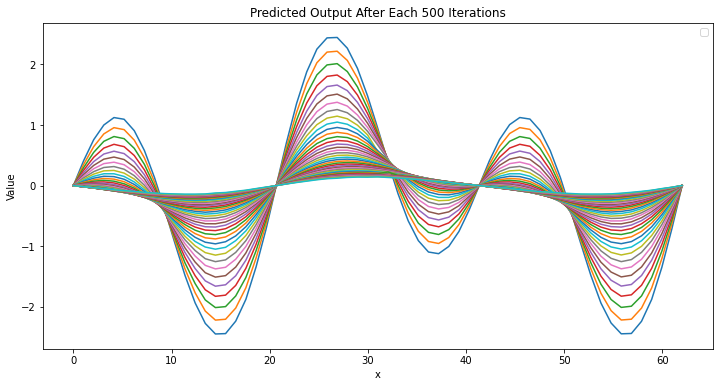

In [511]:

#Training FNO-2D model
import numpy as np
import matplotlib.pyplot as plt
# Initialize
data_loss = DataLoss()
train_dataarr = []
test_dataarr = []
K_pred_list = []
# inputting train_range = [1,2,...,N] re-trains the model N times
train_range = [1]

if not(load_model):
    print('Training the FNO model...\n')
    
    
    # initialize
    data_loss = DataLoss()
    #phys_loss = PhysLoss()
    train_dataarr=[]; train_physarr=[]
    test_dataarr=[]; test_physarr=[]
    #time from the beginning of the computation
    t1 = default_timer()
    # training loop
    for ep in range(1,epochs+1):
        # training and validation
        #time for beginning of each epoch
        #t1 = default_timer()
        train_dloss, train_ploss = train(train_loader)
        test_dloss, test_ploss = test(test_loader)
        train_dataarr.append(train_dloss)
        train_physarr.append(train_ploss)
        test_dataarr.append(test_dloss)
        test_physarr.append(test_ploss)
        t2 = default_timer()
        #print(f'{ep},time= {t2-t1:.03f}, train_dloss = {train_dloss:.03f}, train_ploss = {train_ploss:.03f}, test_dloss = {test_dloss:.03f}, test_ploss = {test_ploss:.03f}')
        print(f'Iteration: {ep}, time = {t2-t1:.08f}, train_dloss = {train_dloss:.08f}, test_dloss = {test_dloss:.08f}')
        # Evaluate the test data using the trained model after each 'epochs_for_graphs' iterations
        if ep % epochs_for_graphs == 0:
            _, K_pred, _, _ = eval_test(test_loader, ntest, s1, s2)
            K_pred_list.append(K_pred)


    # save offline
    print('\n ------ Saving model offline -------')
    print('train mse: ', train_dloss)
    print('test mse: ', test_dloss)
    print('epochs =', epochs)
    #np.save('../models/{}_train_results-{}.npy'.format(mainexpt,expt),[train_dataarr,train_physarr,test_dataarr,test_physarr])
    np.save('../models/{}_train_results_elliptic1-{}.npy'.format(mainexpt,expt),[train_dataarr,test_dataarr])
    torch.save(model, '../models/{}_kmod_elliptic1-{}.pt'.format(mainexpt,expt))
    x_coords = np.linspace(0, 1 +s1, s1)
    # Find the optimal number of layers based on the performance
    optimal_layers_idx = np.argmin(test_dataarr[-1])  # Find the index of the minimum test data loss in the last set
    optimal_layers = train_range[optimal_layers_idx]

    # Save the predicted data for the optimal number of layers
    K_pred_optimal_layers = K_pred_list[optimal_layers_idx]

    # Plot the predicted data after each layer for the optimal number of layers
    plt.figure(figsize=(12, 6))
    for i, layer_output in enumerate(K_pred_optimal_layers):
        plt.plot(x_coords, layer_output)

    plt.title("Predicted Output")
    plt.xlabel("x")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

else:
    print('No training! Testing the FNO model...\n')



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


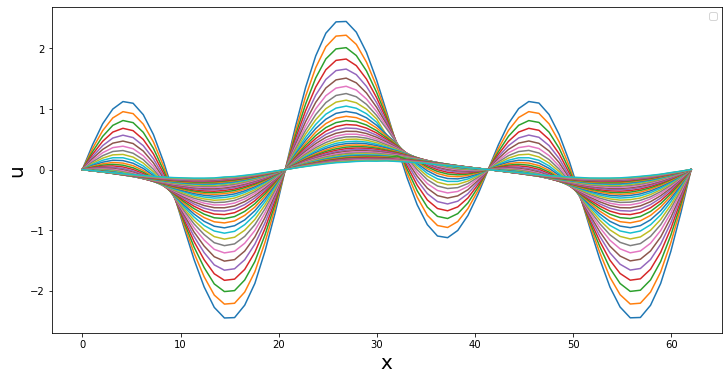

In [512]:
plt.figure(figsize=(12, 6))
for i, layer_output in enumerate(K_pred_optimal_layers):
    plt.plot(x_coords, layer_output)

plt.xlabel('x', fontsize=20)
plt.ylabel('u', fontsize=20)
plt.legend()
plt.savefig('PINO_ellip_500_6.png')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
#This code will output the convergence 
'''
# inputting train_range = [1,2,...,N] re-trains the model N times
train_range = [1]
 

# Training FNO-2D model
print('Training the FNO model...\n')

# Initialize
data_loss = DataLoss()
train_dataarr_4_layers = []
test_dataarr_4_layers = []
K_pred_list = []
K_pred_optimal_layers = []
# Hyperparameter search loop
for num_layers in train_range:
    # Construct the model with the desired number of layers
    model = FNO2d(modes1, modes2, width)
    model.apply(init_weights)
    model.to(device)

    # Initialize optimizer and scheduler for this model
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    # Training loop for the current model
    for ep in range(1, epochs + 1):
        t1 = default_timer()
        train_dloss, _ = train(train_loader)
        test_dloss, _ = test(test_loader)
        train_dataarr_4_layers.append(train_dloss)
        test_dataarr_4_layers.append(test_dloss)
        
        if ep % epochs_for_graphs==0:
            t2 = default_timer()
            print(f'Iteration: {ep}, time = {t2-t1:.03f}, train_dloss = {train_dloss:.03f}, test_dloss = {test_dloss:.03f}')
        _, K_pred, _, _ = eval_test(test_loader, ntest, s1, s2)
        K_pred_list.append(K_pred)

    # Save the predicted data for the optimal number of layers
    if num_layers == optimal_layers:
        K_pred_optimal_layers = K_pred_list

# Reshape the test_dataarr for each num_layers
test_dataarr_4_layers = [test_dataarr_4_layers[i:i + epochs] for i in range(0, len(test_dataarr_4_layers), epochs)]

# Plot the convergence behavior for different numbers of layers
plt.figure(figsize=(10, 6))
for i, num_layers in enumerate(train_range):
    plt.plot(range(epochs), test_dataarr_4_layers[i])

plt.xlabel("Epochs", fontsize=14)  # Adjust the fontsize as needed
plt.ylabel("Test Data Loss", fontsize=14)  # Adjust the fontsize as needed
plt.title("Convergence Behavior One Layer", fontsize=16)  # Adjust the fontsize as needed
plt.legend()
plt.grid(True)

# Save the convergence plot
#plt.savefig('heat_1_layer_conv.png')

# Calculate x_coords
x_coords = np.linspace(0, 1, s1)

# Plot the predicted data after each layer for the optimal number of layers
plt.figure(figsize=(12, 6))
for i, layer_output in enumerate(K_pred_optimal_layers):
    plt.plot(x_coords, layer_output[0])

plt.title("Predicted Output with One Layer")
plt.xlabel("x")
plt.ylabel("Value")

# Save the predicted output plot
#plt.savefig('heat_1_layer_pred.png')

plt.show()
'''

### sorting out data into correct dimensions

In [ ]:
import numpy as np
import pickle as pkl

rdm_exact_1 = np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_1.npy')
rdm_exact_2 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_2.npy')
rdm_exact_3 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_3.npy')
rdm_exact_4 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_4.npy')
rdm_exact_5 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_5.npy')
rdm_exact_6 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_6.npy')
rdm_exact_7 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_7.npy')
rdm_exact_8 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_8.npy')
rdm_exact_9 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_9.npy')
rdm_exact_10 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_10.npy')
rdm_exact_11 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_11.npy')
rdm_exact_12 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_12.npy')
rdm_exact_13 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_13.npy')
rdm_exact_14 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_14.npy')
rdm_exact_15 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_15.npy')
rdm_exact_16 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_16.npy')
rdm_exact_17 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_17.npy')
rdm_exact_18 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_18.npy')
rdm_exact_19 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_19.npy')
rdm_exact_20 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_20.npy')
rdm_exact_21 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_21.npy')
rdm_exact_22 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_22.npy')
rdm_exact_23 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_23.npy')
rdm_exact_24 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_24.npy')
rdm_exact_25 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_25.npy')
rdm_exact_26 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_26.npy')
rdm_exact_27 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_27.npy')
rdm_exact_28 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_28.npy')
rdm_exact_29 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_29.npy')
rdm_exact_30 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_30.npy')
rdm_exact_31 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_31.npy')
rdm_exact_32 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_32.npy')
rdm_exact_33 =np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_33.npy')
rdm_exact_test=np.load('C:/Users/alann/Desktop/Dissertation code/pifno2/data/rdmdata/rdm_exact_test.npy')



In [ ]:
import os


train_cases = ['rdm_exact_1', 'rdm_exact_2', 'rdm_exact_3', 'rdm_exact_4', 'rdm_exact_5',
                         'rdm_exact_6', 'rdm_exact_7', 'rdm_exact_8', 'rdm_exact_9', 'rdm_exact_10',
                         'rdm_exact_11', 'rdm_exact_12', 'rdm_exact_13', 'rdm_exact_14', 'rdm_exact_15',
                         'rdm_exact_16', 'rdm_exact_17', 'rdm_exact_18', 'rdm_exact_19', 'rdm_exact_20',
                         'rdm_exact_21', 'rdm_exact_22', 'rdm_exact_23', 'rdm_exact_24', 'rdm_exact_25',
                         'rdm_exact_26', 'rdm_exact_27', 'rdm_exact_28', 'rdm_exact_29', 'rdm_exact_30',
                         'rdm_exact_31', 'rdm_exact_32', 'rdm_exact_33']


save_folder = r'C:\Users\alann\Desktop\Dissertation code\pifno2\data\train'

for sc in train_cases:
    print(f'Testing input conditions: {sc}')
    
    TestX = []
    TestY = []

    # Load the data arrays using globals()
    K_data = globals()[sc]
    
    # Create input-output pair, i.e., directly use the data arrays
    K_out = K_data.astype('float32')
    K_inp = K_data.astype('float32')
    TestX.append(K_inp)
    TestY.append(K_out)
        
    # Save data offline    
    data = {'X': TestX, 'Y': TestY}
    
    with open(os.path.join(save_folder, 'train-{}.pkl'.format(sc)), 'wb') as f:
        pkl.dump(data, f, protocol=pkl.HIGHEST_PROTOCOL)